In [ ]:
%pylab inline

In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp


In [ ]:
import pystan

In [ ]:
# Target distribution is proportional to: `exp(-x (1 + x))`.
normal = tfp.distributions.Normal

# def unnormalized_log_prob(x):
#   return -x - x**2.
def log_prob(x):
    if len(x.shape) > 1:
        yp = normal(0, 3).log_prob(x[:, 0])
        xp = tf.reduce_sum(tf.stack([normal(0, tf.exp(x[:, 0]/2.)).log_prob(x[:, i]) for i in range(1, x.shape[1])], 1), 1)
    else:
        yp = normal(0, 3).log_prob(x[0])
#         xp = sum([normal(0, tf.exp(x[0]/2.)).log_prob(x[i]) for i in range(1, x.shape[0])])
        xp = tf.reduce_sum([normal(0, tf.exp(x[0]/2.)).log_prob(x[i]) for i in range(1, x.shape[0])])
    return yp + xp
#     return  -y**2 / 9. -x**2/tf.exp(y)



In [ ]:
from scipy.stats import norm
fig, ax = plt.subplots()
r = 2000
x, v = np.meshgrid(np.linspace(-20, 20, r).astype(float32), np.linspace(-9, 9, r).astype(float32))
x, v = np.meshgrid(np.linspace(-100, 100, r).astype(float32), np.linspace(-10, 10, r).astype(float32))
xx = np.stack([v.flatten(), x.flatten()]).T
logp2 = log_prob(xx).numpy()
im = ax.imshow(logp2.reshape(r, r), vmin=-7.5, vmax=-2.5, cmap="viridis", origin="lower")
plt.colorbar(im)
ax.set_yticks([])
ax.set_yticklabels([])
ax.set_xticks(np.linspace(0, r-1, 5))
ax.set_xticklabels(np.linspace(x.min(), x.max(), 5).astype(int))
ax.set_xlabel("$x_0$")

xtrue, ytrue, ptrue = v, x, logp2.reshape(r, r)

In [ ]:
nchains = 10
ndim = 1
initstate = tf.random.uniform([nchains, ndim+1], -1., 1. )
initstate;

In [ ]:
# Initialize the HMC transition kernel.
num_results = int(10e3)
num_burnin_steps = int(1e3)
hmc = tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=log_prob,
        num_leapfrog_steps=30,
        step_size=0.1)

# Run the chain (with burn-in).
@tf.function
def run_chain():
    # Run the chain (with burn-in).
    samples, is_accepted = tfp.mcmc.sample_chain(
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      current_state= initstate,
      kernel=hmc,
#         trace_fn=lambda _, pkr: pkr.inner_results.is_accepted, 
        trace_fn=lambda _, pkr: [pkr.is_accepted,
                                 pkr.accepted_results.step_size,
                             pkr.log_accept_ratio],
        parallel_iterations=20)

    return samples, is_accepted

##
start = time.time()
tfsamples, is_accepted = run_chain()
print(time.time()-start)
tfsamples = tfsamples.numpy()

<ipython-input-10-594443c7e57a>:5: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax[2].pcolormesh(xtrue, ytrue, (ptrue), cmap="viridis", vmin=-7, vmax=-2)


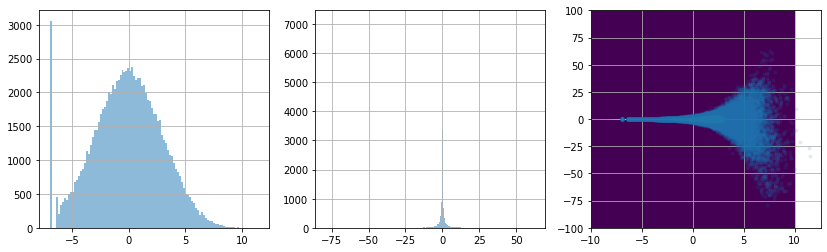

In [10]:
fig, ax = plt.subplots(1, 3, figsize=(14, 4))
ax[0].hist(tfsamples[...,0].flatten(), bins='auto', alpha=0.5)
ax[1].hist(tfsamples[...,1].flatten(), bins='auto', alpha=0.5)
ax[2].pcolormesh(xtrue, ytrue, (ptrue), cmap="viridis", vmin=-7, vmax=-2)
ax[2].plot(tfsamples[...,0].flatten(), tfsamples[...,1].flatten(),'.', alpha=0.1)
for axis in ax: axis.grid(which='both')

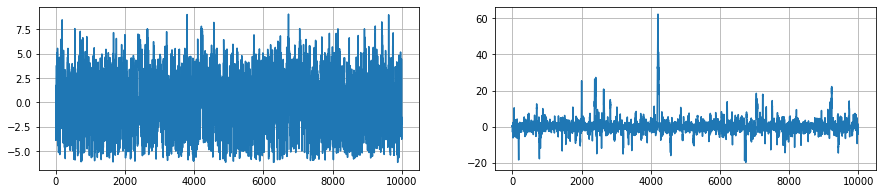

In [11]:
fig, ax = plt.subplots(1, ndim+1, figsize=(15, 3))
for i in range(len(ax)):
    ax[i].plot(tfsamples[:, 0, i])
    ax[i].grid()

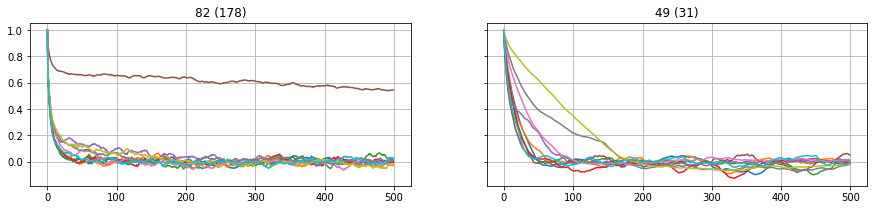

In [12]:
fig, ax = plt.subplots(1, ndim+1, figsize=(15, 3), sharex=True, sharey=True)
for i in range(len(ax)):
    x = tfsamples[...,i]
    xp = (x - x.mean(axis=0))/x.std(axis=0)
    rcc = np.array([np.correlate(xp[:, i], xp[:, i], mode='full') for i in range(xp.shape[1])])
    rcc = rcc[:, rcc.shape[1]//2:].T
    rcc /= rcc[0]
    ax[i].plot(rcc[:500])
    ax[i].grid()
    #
    tcc = []
    for j in range(x.shape[1]):
        for m in range(500):
            if m > 5*(1 + 2*rcc[:m, j].sum()): break
        tcc.append((1 + 2*rcc[:m, j].sum()))
    tcc = np.array(tcc)
    ax[i].set_title('%d (%d)'%(tcc.mean(), tcc.std()))

# PyStan

In [12]:
# model_code_funnel = """
# parameters {
#   real v; 
#   real theta;
# }


# model {
# v ~ normal(0, 3);
# theta ~ normal(0, exp(v/2));
# }
# """

def save_model(obj, filename):
    """Save compiled models for reuse."""
    import pickle
    with open(filename, 'wb') as f:
        pickle.dump(obj, f, protocol=pickle.HIGHEST_PROTOCOL)

def load_model(filename):
    """Reload compiled models for reuse."""
    import pickle
    return pickle.load(open(filename, 'rb'))


fname = '../scripts/models/funnel_%sdim.pkl'%(ndim+1)
# fname = None #'./scripts/models/funnel_2dim.pkl'

start = time.time()
try:
    sm_funnel = load_model(fname)
    print("Model loaded from %s"%fname, sm_funnel)
except Exception as e:
    print(e)
    sm_funnel = pystan.StanModel(model_code=model_code_funnel)
    save_model(sm_funnel, fname)
    print("model saved in %s"%fname)

print("Time to make model : ", time.time()-start)


Model loaded from ../scripts/models/funnel_2dim.pkl StanModel object 'anon_model_f6b01374fc24df6347f85db6821c6077' coded as follows:

parameters {
  real v; 
  real theta;
}


model {
v ~ normal(0, 3);
theta ~ normal(0, exp(v/2));
}

Time to make model :  0.6067230701446533


In [13]:
start = time.time()
stansamples = sm_funnel.sampling(iter=100000, chains=1, algorithm="HMC", seed=100, n_jobs=1, warmup=1000, 
                             init=1,  #[{'v':i[0], 'theta':i[1:]} for i in initstate.numpy()[0:1]],
                     control={"stepsize":0.1, 
                                "adapt_t0":False,
                                "adapt_delta":False,
                                "adapt_kappa":False,
                                "metric":"unit_e",
                              "int_time":5
                                })
end = time.time()
print(end - start)

4.862297773361206


In [14]:
ss = stansamples.extract()
ss['v']
# ss = np.hstack([ss['v'].reshape(-1, 1), ss['theta']])
ss = np.array([ss[i] for i in ss.keys()])

NameError: name 'tfsamples' is not defined

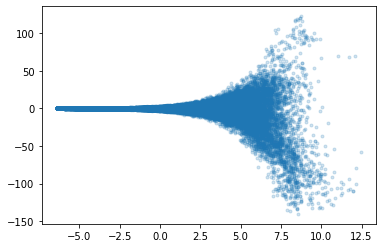

In [15]:
# plt.plot(ss['v'], ss['theta'][:, 0], '.')
plt.plot(ss[0], ss[1], '.', alpha=0.2)
plt.plot(tfsamples[...,0].flatten(), tfsamples[...,1].flatten(),'.', alpha=0.1)
plt.pcolormesh(xtrue, ytrue, (ptrue), cmap="Greens", vmin=-20, vmax=-1)


# Pystan hmc

In [16]:
pyV = stansamples.log_prob
pyV_g = stansamples.grad_log_prob

def pyKE(p):
    return 0.5 * (p**2).sum()

def pyKE_g(p):
    return p

def pyH(q,p):
    return pyV(q) *-1. + pyKE(p)

    
# def pyleapfrog(N, q, p, step_size):
#     q0, p0 = q, p
#     p = p - 0.5*step_size * pyV_g(q) *-1.
#     for i in range(N-1):
#         q = q + step_size * pyKE_g(p)
#         if np.isnan(q.sum()) or np.isinf(q.sum()): return q0, p0
#         p = p - step_size * pyV_g(q) *-1.
#     q = q + step_size * pyKE_g(p)
#     if np.isnan(q.sum()) or np.isinf(q.sum()): return q0, p0
#     p = p - 0.5*step_size * pyV_g(q) *-1.
#     return q, p

def pyleapfrog(N, q, p, step_size):
    q0, p0 = q, p
    try:
        p = p - 0.5*step_size * pyV_g(q) *-1.
        for i in range(N-1):
            q = q + step_size * pyKE_g(p)
            p = p - step_size * pyV_g(q) *-1.
        q = q + step_size * pyKE_g(p)
        p = p - 0.5*step_size * pyV_g(q) *-1.
        return q, p
    except: return q0, p0

def pymetropolis(qp0, qp1):
    q0, p0 = qp0
    q1, p1 = qp1
    H0 = pyH(q0, p0)
    H1 = pyH(q1, p1)
    prob = np.exp(H0 - H1)
    if np.isnan(prob): 
        return q0, p0, 2.
    if np.random.uniform(size=1) > min(1, prob):
        return q0, p0, 0.
    else: return q1, p1, 1.
        
    
def pyhmc_step(q, N, step_size):
    p = np.random.normal(size=q.size).reshape(q.shape)
    q1, p1 = pyleapfrog(N, q, p, step_size)
    q, p, accepted = pymetropolis([q, p], [q1, p1])
    return q

def pyhmc_step_qp(q, p, N, step_size):
    q1, p1 = pyleapfrog(N, q, p, step_size)
    q, p, accepted = pymetropolis([q, p], [q1, p1])
    return q






In [17]:
qq = initstate.numpy().astype(float32)
pp = np.random.normal(size=qq.size).reshape(qq.shape).astype(qq.dtype)


In [18]:
def hmc_step2(q, p, N, step_size, two_factor):
#     q1, p1 = self.leapfrog(q, p, N, step_size)
    q1, p1 = pyleapfrog(N, q, p, step_size)
    accepted = False
    H0 = pyH(q, p)
    H1 = pyH(q1, p1)
    prob1 = np.exp(H0 - H1)
    if np.isnan(prob1) or (q-q1).sum()==0:
        prob1 = 0.   ##since prob1 = 1. if q == q1
        accepted = False
    prob1 = min(1., prob1)
    if np.random.uniform(size=int(1)) > prob1:
        accepted = False
    else:
        accepted = True
    #
    if False : #accepted:
        return q1, p1, 1., prob1 #[H0, H1, H0, H1]
    else:
        N2 = int(N*two_factor)
        s2 = step_size/two_factor
        q2, p2 = pyleapfrog(N2, q, p, s2)
        H2 = pyH(q2, p2)
        prob2 = np.exp(H0 - H2)
        if np.isnan(prob2) or (q-q2).sum()==0:
            return q, p, -1., [prob1, prob2]#[H0, H1, H2, H1]
            accepted = False
        else:
            q21, p21 = pyleapfrog(N, q2, -p2, step_size)
            H21 = pyH(q21, p21)
            prob21 = np.exp(H2 - H21)

            if prob1 == 1:
                import sys
                print("prob1 should not be 1")
#                 sys.exit()
    
            prob = prob2 * (1.-min(1., prob21))/(1.-prob1)
            print(prob, prob2, prob21, prob1)
            if np.isnan(prob) or np.isinf(prob)  :
                prob = 0.
                return q, p, -1, [prob1, prob] #[H0, H1, H2, H21]
            
            prob = min(1., prob)
            if np.random.uniform(size=int(1)) > prob:
                return q, p, 0., [prob1, prob] #[H0, H1, H2, H21]
            else:
                return q2, p2, 2., [prob1, prob] #[H0, H1, H2, H21]



In [77]:
Nleapfrog = 10
step_size = 0.1
fsub = 2
        
def pyleapfrog2(N, q, p, s):
    return q + s*10*sign(p[0]), p

    
def get_num(m, q, p, N=Nleapfrog, ss=step_size): 
    
    avec = np.zeros(m)
#     print('get num called')
    H0 = pyH(q, p)    
    for j in range(m):
#         print("get step", m, j)
        fac = fsub**(j)
        qj, pj = pyleapfrog(N*fac, q, p, ss/fac)
        Hj = pyH(qj, pj)
        pfac = np.exp(H0 - Hj)
        if  (q - qj).sum()==0: 
            pfac = 0.
        if j:
            den = np.prod(1-avec[:j-1])
            num = get_num(j, qj, -pj, N, ss)
            prob = pfac*num/den
        else: 
            prob = pfac
        if np.isnan(prob) or np.isinf(prob): 
             return np.nan
        else: avec[j] = min(1., prob)
        if np.prod(1-avec): _
        else: 
            return np.prod(1-avec)
    return np.prod(1-avec)
        
        
def multi_step(m, q0, p0, N=Nleapfrog, ss=step_size):
    avec = np.zeros(m)
    H0 = pyH(q0, p0)
    q1, p1 = pyleapfrog(N, q0, p0, ss)
    H1 = pyH(q1, p1)
    pfac = np.exp(H0 - H1)
    if (q0 - q1).sum()==0: 
        pfac = 0.
    prob = pfac
    if np.isnan(prob) or np.isinf(prob): 
        prob = 0.
    avec[0] = min(1., prob)
    acc = np.random.uniform()
    
    if  acc <= avec[0]: 
        return q1, p1, 0, avec
    else:  
        for j in range(1, m):
            fac = fsub**(j)
            qj, pj = pyleapfrog(N*fac, q0, p0, ss/fac)
#             print("multi step", j)
            Hj = pyH(qj, pj)
            pfac = np.exp(H0 - Hj)
            if  (q0 - qj).sum()==0: 
#                 print('Dont move')
                pfac = 0.
            den = np.prod(1-avec[:j])
            num = get_num(j, qj, -pj, N, ss)
            prob = pfac*num/den
#             print(prob, pfac, 1-num, 1-den)
            if np.isnan(prob) or np.isinf(prob): 
                prob = 0.
            avec[j] = min(1., prob)
            acc = np.random.uniform()
#             print('accept if : ', acc, avec)
            if acc < avec[j]: 
                return qj, pj, j, avec
        return q0, p0, -1, avec

SyntaxError: invalid syntax (<ipython-input-77-e6faac7a28c5>, line 29)

In [76]:
            
iq = np.random.uniform(-1., 2., 2).reshape(-1, 2)
ip = np.random.normal(size=2).reshape(-1, 2)

print(hmc_step2(iq, ip, 10, 0.9, 2)[-1])
print('multi')
print(multi_step(2, iq, ip, 10, 0.9)[-1])



1.3962957046789874 1.3962957046789874 1.8911105811336256e-102 4.902267367361896e-65
[4.902267367361896e-65, 1.0]
multi
1.3962957046789874 1.3962957046789874 0.0 0.0
[4.90226737e-65 1.00000000e+00]


In [889]:
iids = []
for _ in range(1000):
    iq = np.random.uniform(-1., 1., 2).reshape(-1, 2)
    ip = np.random.normal(size=2).reshape(-1, 2)
    # print(iq, ip)
    N = Nleapfrog
    ss = 3.0#step_size
    try: iids.append(multi_step(4, iq, ip, 10, ss))
    except Exception as e: print(e)

<ipython-input-698-c4ceb936a39c>:5: RuntimeWarning: overflow encountered in square
  return 0.5 * (p**2).sum()
<ipython-input-888-a0acd0759a5c>:20: RuntimeWarning: invalid value encountered in subtract
  if  (q - qj).sum()==0:
<ipython-input-698-c4ceb936a39c>:29: RuntimeWarning: invalid value encountered in subtract
  p = p - 0.5*step_size * pyV_g(q) *-1.
<ipython-input-888-a0acd0759a5c>:19: RuntimeWarning: invalid value encountered in double_scalars
  pfac = np.exp(H0 - Hj)
<ipython-input-698-c4ceb936a39c>:32: RuntimeWarning: overflow encountered in multiply
  p = p - step_size * pyV_g(q) *-1.


In [469]:
iids;

In [890]:
pysamples = []

Nleap, step_size = 20, 0.5
start = time.time()
q = qq[0]
nsamples = 10000
for i in range(nsamples):
    q = pyhmc_step(q, Nleap, step_size)
    pysamples.append(q)
q = np.array(q)
end = time.time()
print(end - start)
pysamples = np.array(pysamples)

1.8217380046844482


In [891]:
pysamples2 = []
accid2 = []
avec2 = []

start = time.time()
q = qq[0]
nsamples = 10000
for i in range(nsamples):
    p = np.random.normal(size=q.size).reshape(q.shape)
    q, p, acc, av = multi_step(2, q, p, Nleap, step_size)
    pysamples2.append(q)
    accid2.append(acc)
    avec2.append(av)
end = time.time()
print(end - start)
pysamples2 = np.array(pysamples2)

4.5435450077056885


In [892]:
pysamples3 = []
accid3 = []
avec3 = []
start = time.time()
q = qq[0]
nsamples = 10000
for i in range(nsamples):
    p = np.random.normal(size=q.size).reshape(q.shape)
    q, p, acc, av = multi_step(3, q, p, Nleap, step_size)
    pysamples3.append(q)
    accid3.append(acc)
    avec3.append(av)

end = time.time()
print(end - start)
pysamples3 = np.array(pysamples3)

7.628743886947632


<ipython-input-888-a0acd0759a5c>:19: RuntimeWarning: overflow encountered in exp
  pfac = np.exp(H0 - Hj)


In [893]:
pysamples4 = []
accid4 = []
avec4 = []

start = time.time()
q = qq[0]
nsamples = 10000
for i in range(nsamples):
    p = np.random.normal(size=q.size).reshape(q.shape)
    q, p, acc, av = multi_step(4, q, p, Nleap, step_size)
    pysamples4.append(q)
    accid4.append(acc)
    avec4.append(av)
end = time.time()
print(end - start)
pysamples4 = np.array(pysamples4)

<ipython-input-888-a0acd0759a5c>:19: RuntimeWarning: overflow encountered in exp
  pfac = np.exp(H0 - Hj)


12.217796802520752


In [894]:
np.unique(accid2, return_counts=True), np.unique(accid3, return_counts=True), np.unique(accid4, return_counts=True)

((array([-1,  0,  1]), array([3163, 5080, 1757])),
 (array([-1,  0,  1,  2]), array([1758, 5268, 1766, 1208])),
 (array([-1,  0,  1,  2,  3]), array([1327, 5108, 1780, 1257,  528])))

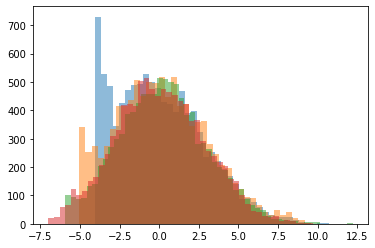

In [895]:
plt.hist(pysamples[:, 0], bins='auto', alpha=0.5);
plt.hist(pysamples2[:, 0], bins='auto', alpha=0.5);
plt.hist(pysamples3[:, 0], bins='auto', alpha=0.5);
plt.hist(pysamples4[:, 0], bins='auto', alpha=0.5);
# plt.xlim(-10, 10)

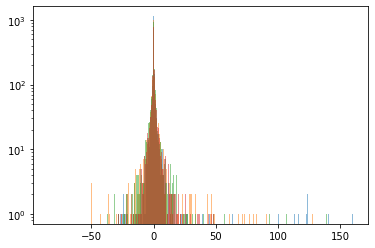

In [896]:
plt.hist(pysamples[:, 1], bins='auto', alpha=0.5);
plt.hist(pysamples2[:, 1], bins='auto', alpha=0.5);
plt.hist(pysamples3[:, 1], bins='auto', alpha=0.5);
plt.hist(pysamples4[:, 1], bins='auto', alpha=0.5);
plt.yscale('log')

0
0.034420468628341666 2.7706773620815386 0.779711305292428 9.813918483938798
1
0.16916793779749995 2.9323628711992424 0.7822422230321013 9.814007338501762
2
0.2395200549789156 2.779227102179245 0.761546301256876 9.305601573864486
3
0.08031931561742489 2.805343372955249 0.28703268157786144 4.845639748704175


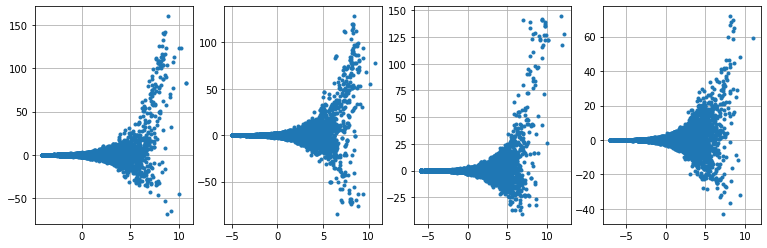

In [897]:
allpy = [pysamples, pysamples2, pysamples3, pysamples4]

fig, ax = plt.subplots(1, 4, figsize=(13, 4))
for i in range(4):
    print(i)
    ax[i].plot(allpy[i][:, 0], allpy[i][:, 1], '.')
    ax[i].grid(which='both')
    print(allpy[i][:, 0].mean(), allpy[i][:, 0].std(), allpy[i][:, 1].mean(), allpy[i][:, 1].std())

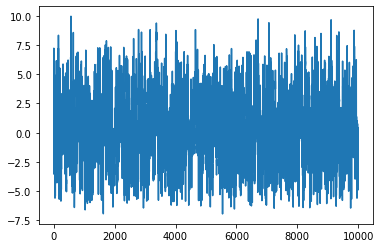

In [741]:
plt.plot(pysamples4[:,0])

In [265]:
# mysamples = tf.TensorArray(dtype=tf.float32, size=nsamples)
# i = tf.constant(0)

# def hmc_body(i, q, mysamples):
#     q = tf.map_fn(hmc_step, q, parallel_iterations=nparallel)
#     samples = mysamples.write(i, q)
#     return i+1, q, samples

# def cond(i, q, samples):
#     return tf.less(i, tf.constant(nsamples))

# start = time.time()
# i, q, mysamples = tf.while_loop(cond, hmc_body, [i, initstate, samples], parallel_iterations=nparallel)
# end = time.time()
# print(end - start)
# mysamples = mysamples.stack().numpy()